# Imports

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# Loading Data

In [2]:
with open("options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [3]:
RUG = pd.read_pickle(options['RUG_obfuscated'])

# Preparing and Transforming Data

In [4]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [5]:
groups = RUG['Location 2 - consumption'].groupby(pd.Grouper(freq='D'))

# get the calender date of the groups
days = list(groups.first().index.strftime('%Y:%m:%d'))

gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

temp = pd.concat(gro, axis=1, keys=days)

temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

# drop all columns of temp dataframe which contain nan values
temp.dropna(axis=1, how='any', inplace=True)

In [6]:
temp = temp[::10]

In [7]:
train_percentage = 0.8
train_size = int(len(temp.columns) * train_percentage)
train_size

1702

In [8]:
train = temp.iloc[:, :train_size]
test = temp.iloc[:, train_size:]

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [10]:
scaled_list_train = [train[col] for col in train]


scaled_list_train = scaler.fit_transform(scaled_list_train)
scaled_list_train

array([[0.17881265, 0.17840637, 0.18230088, ..., 0.09634284, 0.09634284,
        0.12386668],
       [0.04017064, 0.03969576, 0.04424779, ..., 0.13174732, 0.13174732,
        0.1581928 ],
       [0.15926058, 0.22678519, 0.23379805, ..., 0.09465692, 0.09465692,
        0.12223211],
       ...,
       [0.02986136, 0.02724738, 0.05734513, ..., 0.17659299, 0.16445432,
        0.19578807],
       [0.12584429, 0.13608185, 0.09132743, ..., 0.07341423, 0.069368  ,
        0.16048121],
       [0.07038748, 0.0784636 , 0.08495575, ..., 0.07341423, 0.05115998,
        0.08790598]])

In [11]:
scaled_list_test = [test[col] for col in test]

scaled_list_test = scaler.transform(scaled_list_test)

scaled_list_test

array([[0.0234625 , 0.02084535, 0.0339823 , ..., 0.16850054, 0.24537884,
        0.19382658],
       [0.14077497, 0.11474176, 0.14654867, ..., 0.21300902, 0.20289347,
        0.15851971],
       [0.13224316, 0.04218544, 0.04035398, ..., 0.18670856, 0.17456989,
        0.21148001],
       ...,
       [0.01919659, 0.00804129, 0.05309735, ..., 0.08959913, 0.13208451,
        0.08790598],
       [0.08745111, 0.0101753 , 0.01486726, ..., 0.1604081 , 0.08352979,
        0.11928987],
       [0.06612158, 0.11687577, 0.21663716, ..., 0.12399206, 0.04913687,
        0.08594449]])

# Principal Component Analysis

In [12]:
pca = PCA(n_components=0.85, svd_solver='full')
 
# Fit and transform data
pca_features = pca.fit_transform(scaled_list_train)


In [13]:
from collections import Counter
kmeans_pca = TimeSeriesKMeans(n_clusters=4, metric="dtw", n_jobs=-1).fit(pca_features)
train_pca_features = kmeans_pca.predict(pca_features)
# counts = dict(Counter(train_pca_features))
# counts

c:\Users\mjnst\anaconda3\envs\thesis\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1702 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


# Train different lstm models

In [14]:
look_back=3

In [15]:
Counter(train_pca_features == 0)


Counter({True: 281, False: 1421})

In [16]:
len(np.where(train_pca_features == 0)[0])

281

In [17]:
cat_0 = scaled_list_train[np.where(train_pca_features == 0)].flatten().reshape(-1, 1)
cat_0

array([[0.17881265],
       [0.17840637],
       [0.18230088],
       ...,
       [0.1158996 ],
       [0.08150668],
       [0.09379046]])

In [18]:
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
# cat_0.reshape(-1, 1).tolist()

In [20]:


train_x_list, train_y_list = create_dataset(cat_0, look_back=3)
train_y_list.shape
# for i in scaled_list_train[np.where(train_pca_features == 0)].T:
#     x, y = create_dataset(i.reshape(-1, 1))
#     train_x_list.append(np.reshape(x, (x.shape[0], 1, x.shape[1])))
#     train_y_list.append(y)


(40460,)

In [21]:
train_x_list = np.reshape(train_x_list, (train_x_list.shape[0], 1, train_x_list.shape[1]))

In [22]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(train_x_list, train_y_list, epochs=25, verbose=2, callbacks=[callback], batch_size=128)

# make predictions
trainPredict = model.predict(train_x_list)

Epoch 1/25
317/317 - 6s - loss: 0.0302 - mse: 0.0302 - 6s/epoch - 19ms/step
Epoch 2/25
317/317 - 3s - loss: 0.0142 - mse: 0.0142 - 3s/epoch - 10ms/step
Epoch 3/25
317/317 - 3s - loss: 0.0117 - mse: 0.0117 - 3s/epoch - 9ms/step
Epoch 4/25
317/317 - 3s - loss: 0.0099 - mse: 0.0099 - 3s/epoch - 9ms/step
Epoch 5/25
317/317 - 3s - loss: 0.0092 - mse: 0.0092 - 3s/epoch - 8ms/step
Epoch 6/25
317/317 - 3s - loss: 0.0091 - mse: 0.0091 - 3s/epoch - 8ms/step
Epoch 7/25
317/317 - 2s - loss: 0.0091 - mse: 0.0091 - 2s/epoch - 8ms/step
Epoch 8/25
317/317 - 4s - loss: 0.0091 - mse: 0.0091 - 4s/epoch - 11ms/step
Epoch 9/25
317/317 - 3s - loss: 0.0091 - mse: 0.0091 - 3s/epoch - 9ms/step
Epoch 10/25
317/317 - 2s - loss: 0.0091 - mse: 0.0091 - 2s/epoch - 8ms/step
Epoch 11/25
317/317 - 3s - loss: 0.0091 - mse: 0.0091 - 3s/epoch - 8ms/step
Epoch 12/25
317/317 - 3s - loss: 0.0091 - mse: 0.0091 - 3s/epoch - 9ms/step
Epoch 13/25
317/317 - 3s - loss: 0.0091 - mse: 0.0091 - 3s/epoch - 9ms/step
Epoch 14/25
317/31

# Predict test data clusters

In [24]:
test_pca_features = kmeans_pca.predict(scaled_list_test)

c:\Users\mjnst\anaconda3\envs\thesis\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 426 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


<BarContainer object of 2 artists>

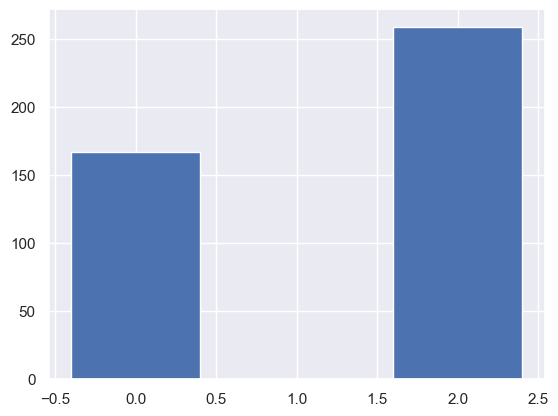

In [25]:
plt.bar(dict(Counter(test_pca_features)).keys(), dict(Counter(test_pca_features)).values())

In [109]:
np.where(test_pca_features == 0)

(array([ 15,  19,  32,  36,  97,  98, 112, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
        216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
        242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
        255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
        268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
        281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
        294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
        307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
        320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
        333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
        346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 405], dtype=int64),)

In [113]:
te = scaled_list_test[15]
testX, testY = create_dataset(te.reshape(-1, 1), look_back)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [114]:
testPredict = model.predict(testX)

5/5 [==============================] - 0s 6ms/step


In [136]:
ta = scaled_list_test[15:15+look_back]

In [137]:
scaler.inverse_transform(ta.reshape(1, -1))

ValueError: operands could not be broadcast together with shapes (1,432) (144,) (1,432) 

In [14]:
scaled_list_test[np.where(test_pca_features == 0)]


NameError: name 'test_pca_features' is not defined

In [82]:
arrays = []
for i in range(len(np.where(test_pca_features == 0)[0])):
    test_0 = scaled_list_test[np.where(test_pca_features == 0)][i]
    testX, testY = create_dataset(test_0.reshape(-1, 1), look_back)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict = model.predict(testX)
    arrays.append(testPredict)

5/5 [==============================] - 0s 6ms/step


In [93]:
aa = np.concatenate(arrays, axis=1)

In [103]:
aa.T.shape

(167, 140)

In [101]:
scaled_list_test.shape

(426, 144)

In [106]:
scaled_list_test[np.where(test_pca_features == 0)].shape

(167, 144)

In [108]:
scaler.inverse_transform(scaled_list_test[np.where(test_pca_features == 0)])

array([[2.54399991, 2.56705519, 2.62800002, ..., 0.49200001, 0.60000002,
        0.49200001],
       [0.77999997, 0.792     , 0.792     , ..., 0.46799999, 0.30000001,
        0.69599998],
       [1.09200001, 0.92400002, 1.27199996, ..., 0.228     , 0.27599999,
        0.252     ],
       ...,
       [0.80888069, 0.80888069, 0.80888069, ..., 0.80888069, 0.80888069,
        0.80888069],
       [0.80888069, 0.80888069, 0.80888069, ..., 0.40799999, 0.68400002,
        0.36000001],
       [1.08000004, 1.05599999, 0.94800001, ..., 0.072     , 0.12      ,
        0.12      ]])

In [42]:
rmse_test = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

TypeError: Singleton array 0.23462494833717376 cannot be considered a valid collection.